In [1]:
# pip install opencv-python

In [2]:
import sklearn 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn.metrics import pairwise_distances_argmin
#you can use Python’s imaging library (PIL)
from PIL import Image
from IPython.display import display
# or you can use opencv ## conda install -c conda-forge opencv
import cv2
import scipy.cluster.hierarchy as sch #you only for sch.dendrogram


In [3]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.6,random_state=4)

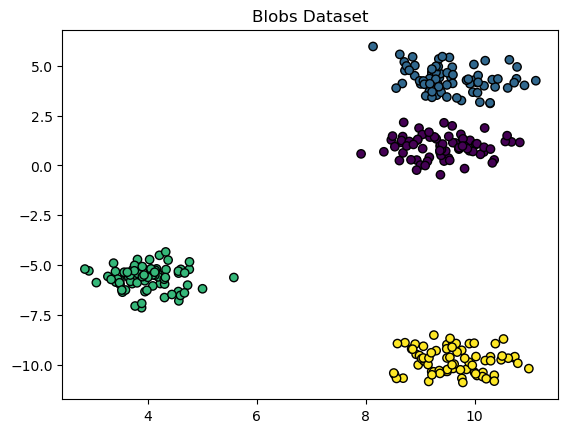

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, marker="o", edgecolor='k')
plt.title('Blobs Dataset')
plt.show()

In [5]:
def euclidean_dist(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [6]:
random_index = np.random.choice(X.shape[0], size=4, replace=False)
centers = X[random_index]
print("centers: \n", centers)
distances = np.sqrt(((X[:, np.newaxis, :] - centers) ** 2).sum(axis=2))
print("\n distances: \n", distances)
closest_center = np.argmin(distances, axis=1)
print("\n indices of the closest center: \n", closest_center)

centers: 
 [[10.37276172  3.94015879]
 [ 9.29040897 -9.29308248]
 [ 3.72370451 -5.22692947]
 [ 8.75080179  0.97730463]]

 distances: 
 [[11.87244417  7.08335798  0.57261532  8.54140755]
 [ 1.71142586 13.41724216 10.56588717  3.13354075]
 [ 1.38494325 14.65495217 12.59295316  4.71552153]
 ...
 [ 2.07081522 11.20676242  9.60126694  1.69060094]
 [10.41763465  6.35168262  1.1096772   7.05133898]
 [ 1.32855021 14.57718842 12.31769747  4.51487912]]

 indices of the closest center: 
 [2 0 0 3 0 2 1 3 3 2 1 1 3 0 3 2 1 0 2 3 1 0 0 1 2 1 2 0 0 0 2 3 2 1 0 1 0
 1 2 3 1 0 0 2 1 2 1 0 3 0 3 3 0 2 3 3 0 2 1 2 2 0 3 1 0 1 3 2 1 0 0 1 0 1
 3 1 2 3 1 2 3 3 3 2 1 3 2 2 0 3 0 2 2 0 0 1 0 0 2 2 2 2 3 3 0 3 0 1 3 1 3
 2 0 0 0 0 1 0 1 0 1 3 0 3 3 0 3 0 2 1 2 0 2 0 3 3 0 0 2 2 2 1 2 1 2 1 2 1
 3 1 3 0 3 1 2 0 0 2 3 1 0 2 2 0 2 1 2 3 0 3 2 2 0 3 0 1 0 1 1 1 1 2 0 1 0
 2 1 0 3 1 2 2 1 3 3 1 1 2 0 0 3 2 3 1 0 1 3 0 1 3 3 2 2 3 3 2 2 2 0 3 3 1
 2 3 0 3 0 1 1 1 3 3 0 1 1 3 1 1 2 2 0 3 2 3 1 1 2 0 2 2 3 1 2 3 1 3

# K-means

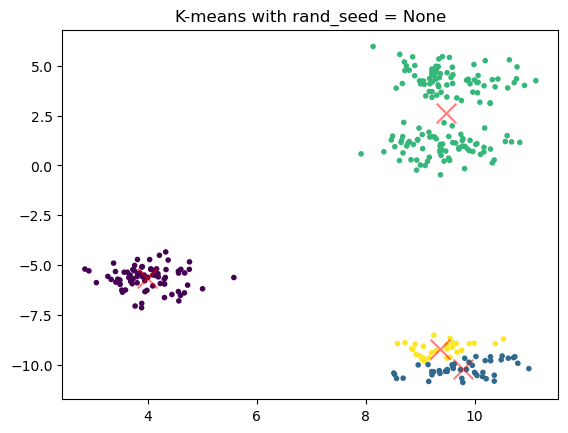

In [7]:
def k_means(X, rand_seed = None, k=4):
    
    if rand_seed is not None:
        np.random.seed(rand_seed)
        
    def calc_centers(X_extended):
        new_centers = []
        
        for i in range(k):  
            cluster = X_extended[X_extended[:, -1] == i]
            if cluster.shape[0] > 0:
                center = np.mean(cluster[:, :-1], axis=0)
            else:
                center = X_extended[np.random.choice(X_extended.shape[0]), :]
                
            new_centers.append(center)

        return np.array(new_centers)


    X_ = np.copy(X)  
    
    random_index = np.random.choice(X_.shape[0], size=k, replace=False)
    centers = X_[random_index, :]  
    
    X_ = np.hstack((X_, np.zeros((X_.shape[0], 1))))

    epsilon = 1e-4
    converged = False

    while not converged:
        
        closest_centers_indices = pairwise_distances_argmin(X_[:, :-1], centers)
        X_[:, -1] = closest_centers_indices  
        new_centers = np.array(calc_centers(X_))

        # check convergence
        if np.all(np.abs(new_centers - centers) < epsilon):
            converged = True
        else:
            centers = new_centers

    return X_, centers

X_, centers = k_means(X)
cluster = X_[:, -1]

plt.scatter(X_[:, 0], X_[:, 1], c=cluster, marker='.')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='x')
plt.title('K-means with rand_seed = None')
plt.show()

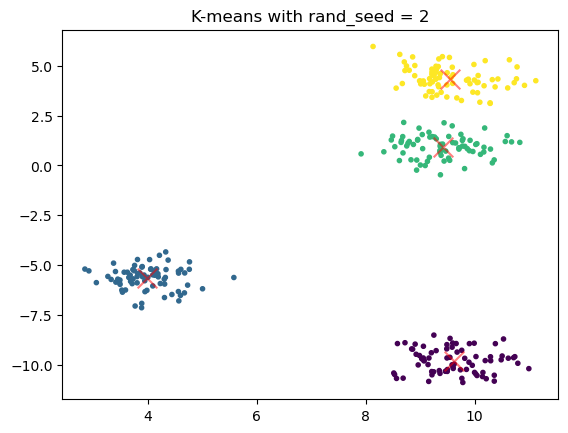

In [8]:
X_, centers = k_means(X, rand_seed = 2)
cluster = X_[:, -1]
plt.scatter(X_[:, 0], X_[:, 1], c=cluster, marker='.')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='x')
plt.title('K-means with rand_seed = 2')
plt.show()


# Comparing

The clustering results with random seed = 2 are highly accurate, correctly classifying all points. However, using random seed = None, which results in different outcomes each time, often leads to misclassification of points, particularly in the groups at the top right, where it sometimes identifies two clusters as one. Yet, it tends to be mostly accurate with the cluster at the bottom right.

From these observations, we can conclude that the initial placement of cluster centers is crucial for the performance of the K-means algorithm. Occasionally, clusters may converge to a local optimum instead of reaching the global optimum. Therefore, for optimization, it can be beneficial to run the algorithm with various random seeds to determine which one yields the best results.








# K-means ++ 

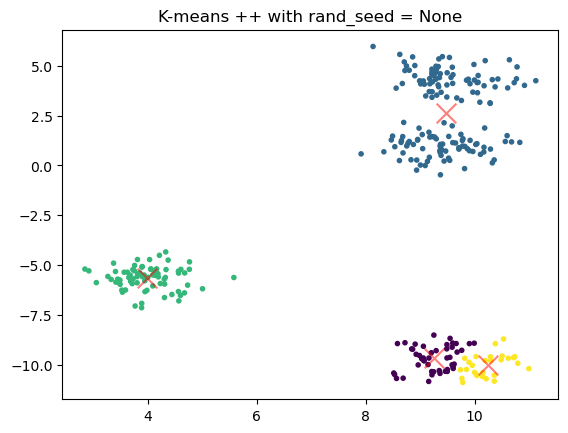

In [9]:
def k_means_plus(X, rand_seed=None, k=4):
    if rand_seed is not None:
        np.random.seed(rand_seed)
        
    def calc_centers(X_extended):
        new_centers = []
        for i in range(k):
            cluster = X_extended[X_extended[:, -1] == i]
            if cluster.shape[0] > 0:
                center = np.mean(cluster[:, :-1], axis=0)
            else:
                center = X_extended[np.random.choice(X_extended.shape[0]), :-1]
            new_centers.append(center)
        return np.array(new_centers)

    def farthest_next_center(X_, current_centers):
        distances = np.array([min([euclidean_dist(x[:-1], center) for center in current_centers]) for x in X_])
        probs = distances**2
        probs = probs/probs.sum()
        best_center = X_[np.random.choice(X_.shape[0], p=probs), :]
        return best_center

    
    X_ = np.copy(X)
    
    # K ++ 
    centers = [X_[np.random.choice(X_.shape[0]), :]]# Choose the first center randomly
    for _ in range(k-1):  
        centers.append(farthest_next_center(X_, centers))

        
    # Create a third column for cluster indices
    X_ = np.hstack((X_, np.zeros((X_.shape[0], 1))))

    epsilon = 1e-4
    converged = False

    while not converged:
        closest_centers_indices = pairwise_distances_argmin(X_[:, :-1], centers)
        X_[:, -1] = closest_centers_indices
        
        new_centers = np.array(calc_centers(X_))
        
        if np.all(np.abs(new_centers - centers) < epsilon):
            converged = True
        else:
            centers = new_centers

    return X_, centers
X_, centers = k_means_plus(X)

cluster = X_[:, -1]
plt.scatter(X_[:, 0], X_[:, 1], c=cluster, marker='.')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='x')
plt.title('K-means ++ with rand_seed = None')
plt.show()


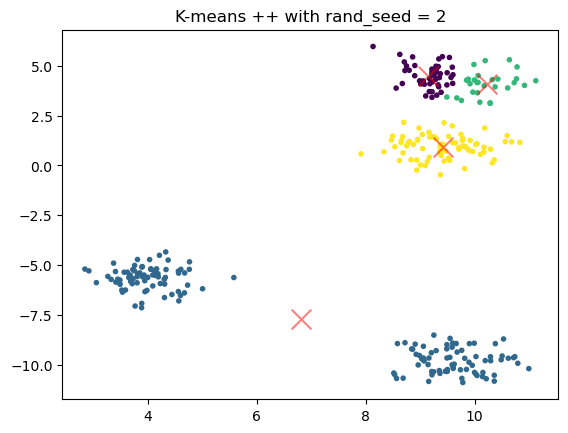

In [10]:
X_, centers = k_means_plus(X, rand_seed = 2)
cluster = X_[:, -1]
plt.scatter(X_[:, 0], X_[:, 1], c=cluster, marker='.')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='x')
plt.title('K-means ++ with rand_seed = 2')
plt.show()


# Comparing

In this case, K-means++ with rand_seed = 2 also classifies all points correctly. Meanwhile, K-means++ with rand_seed = None most often classifies points into clusters more accurately than K-means. However, for some random seeds, it still does not converge to the globally optimal result.


# TESTING ON RGB

In [11]:
def k_means_plus_3d(X, k=4, rand_seed=None):
    if rand_seed is not None:
        np.random.seed(rand_seed)

    # calculate new centers
    def calc_centers(X_extended):
        new_centers = []
        for i in range(k):
            cluster = X_extended[X_extended[:, -1] == i, :-1]
            if cluster.shape[0] > 0:
                center = np.mean(cluster, axis=0)
            else:
                center = X[np.random.choice(X.shape[0]), :]
            new_centers.append(center)
        return np.array(new_centers)

    # select the farthest next center
    def farthest_next_center(X_, current_centers):
        distances = np.array([min(np.linalg.norm(x - center) for center in current_centers) for x in X_])
        probs = distances ** 2
        probs /= probs.sum()
        best_center = X_[np.random.choice(X_.shape[0], p=probs)]
        return best_center

    # initialize the centers using k-means++
    centers = [X[np.random.choice(X.shape[0]), :]]
    for _ in range(k - 1):
        centers.append(farthest_next_center(X, centers))

    X_extended = np.hstack((X, np.zeros((X.shape[0], 1))))

    epsilon = 1e-4 
    converged = False

    while not converged:
        closest_centers_indices = pairwise_distances_argmin(X[:, :], centers)
        X_extended[:, -1] = closest_centers_indices

        new_centers = calc_centers(X_extended)

        # check for convergence
        if np.all(np.abs(new_centers - centers) < epsilon):
            converged = True
        else:
            centers = new_centers

    return X_extended, centers

In [12]:
image = cv2.imread('cropped.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels = image.reshape(-1, 3)
print(pixels)

[[157  67  59]
 [157  67  59]
 [157  67  59]
 ...
 [ 27  22  18]
 [ 24  19  15]
 [ 25  20  16]]


In [13]:
X_, centers = k_means_plus_3d(pixels, k = 7)

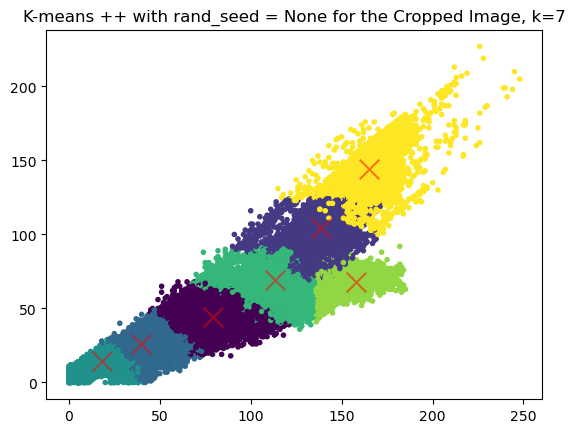

In [14]:
cluster = X_[:, -1]

plt.scatter(X_[:, 0], X_[:, 1], c=cluster, marker='.')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='x')

plt.title('K-means ++ with rand_seed = None for the Cropped Image, k=7')
plt.show()

In [15]:
X_, centers
replaced_pixels = np.array([centers[int(row[-1])] for row in X_])
replaced_pixels

array([[157.83983371,  68.07411187,  60.76133787],
       [157.83983371,  68.07411187,  60.76133787],
       [157.83983371,  68.07411187,  60.76133787],
       ...,
       [ 18.01733471,  14.40296928,  11.58891581],
       [ 18.01733471,  14.40296928,  11.58891581],
       [ 18.01733471,  14.40296928,  11.58891581]])

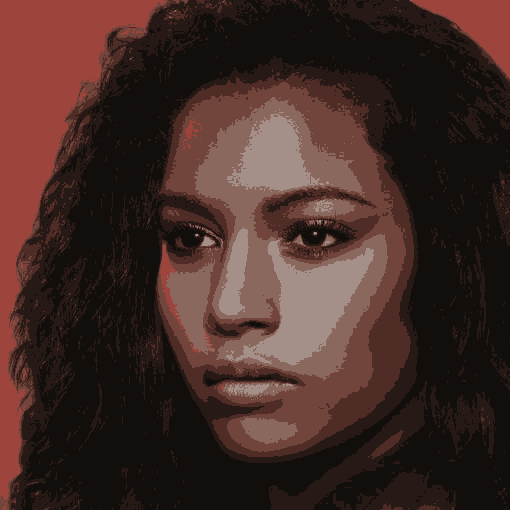

In [16]:
side_length = int(np.sqrt(len(replaced_pixels)))
replaced_pixels_image = replaced_pixels.reshape((side_length, side_length, 3)).astype(np.uint8)

# create the image 
image = Image.fromarray(replaced_pixels_image)
image.save("replaced_pixels_image.png")

display(image)

# Comparing

From our analysis of both simple K-means and K-means++, we have concluded that different random seeds used to initialize the centroids can lead to varying results, indicating that K-means is highly dependent on the initial centroid selection.

Comparing K-means with K-means++, it is evident that K-means++ generally yields better results. After running the algorithms with various random seeds, one can observe that K-means++ is typically more accurate than K-means. Furthermore, K-means++ tends to reach convergence faster than K-means.

In [17]:
import time

def compare_kmeans_performance(X, num_runs=10):

    time_k_means = 0
    time_k_means_plus = 0

    for _ in range(num_runs):
        start = time.time()
        k_means(X)
        end = time.time()
        time_k_means += end - start

        start = time.time()
        k_means_plus(X)
        end = time.time()
        time_k_means_plus += end - start

    return time_k_means/num_runs, time_k_means_plus/num_runs

compare_kmeans_performance(X, num_runs=10)


(0.0006534337997436523, 0.00598907470703125)

# Hierarchical Clustering 

https://datascience.stackexchange.com/questions/12129/derivation-of-wards-formula-for-agglomerative-clustering

In [18]:
df = pd.read_csv('Mall_Customers.csv')
df['Gender'] = df['Gender'].map({'Male': -1, 'Female': 1})
df.set_index('CustomerID', inplace=True)
df.index = df.index - 1

In [19]:
def calculate_wards_distance(a, b):
    """
    Calculate Ward's distance between two clusters.
    """
    a_b_union = np.concatenate([a, b], axis=0)
    m_a, m_b, mean = np.mean(a, axis=0), np.mean(b, axis=0), np.mean(a_b_union, axis=0)

    delta = np.sqrt((np.sum((a_b_union - mean) ** 2) - np.sum((a - m_a) ** 2) - np.sum((b - m_b) ** 2))*2)
    return delta

def calculate_dist_matrix(data):
    n = data.shape[0]
    proximity_matrix = np.zeros((n, n))

    clusters = {i: data.iloc[i].values.reshape(1, -1) for i in range(n)}
    for i in range(n):
        for j in range(i+1, n):
            wards_dist = calculate_wards_distance(clusters[i], clusters[j])
            proximity_matrix[i, j] = wards_dist
            proximity_matrix[j, i] = wards_dist  # The matrix is symmetric

    return proximity_matrix

dist_matrix = calculate_dist_matrix(df)
dist_matrix

array([[  0.        ,  42.04759208,  33.09078422, ..., 117.1110584 ,
        124.47489707, 130.15759678],
       [ 42.04759208,   0.        ,  75.03998934, ..., 111.7631424 ,
        137.74614332, 122.34786471],
       [ 33.09078422,  75.03998934,   0.        , ..., 129.89226305,
        122.20065466, 143.78456106],
       ...,
       [117.1110584 , 111.7631424 , 129.89226305, ...,   0.        ,
         57.07013229,  14.35270009],
       [124.47489707, 137.74614332, 122.20065466, ...,  57.07013229,
          0.        ,  65.03076195],
       [130.15759678, 122.34786471, 143.78456106, ...,  14.35270009,
         65.03076195,   0.        ]])

In [20]:
def hierarchical_clustering(dist_matrix, data):
    n = len(dist_matrix)
    new_ind = n
    np.fill_diagonal(dist_matrix, np.inf)
    
    clusters = {}
    for i in range(n):
        clusters[i] = [i]
    linkage = np.zeros((n - 1, 4))

    expanded_dists = np.full((n*2, n*2), np.inf)
    expanded_dists[:n, :n] = dist_matrix

    for k in range(n - 1):
        if len(clusters) == 1:
            break

        i, j = np.unravel_index(np.argmin(expanded_dists[:new_ind, :new_ind]), (new_ind, new_ind))
        new_cluster_data = np.concatenate([data.iloc[clusters[i]].values, data.iloc[clusters[j]].values], axis=0)

        linkage[k] = [i, j,expanded_dists[i, j], 0]

        clusters[new_ind] = []
        clusters[new_ind].extend(clusters[i])
        clusters[new_ind].extend(clusters[j])
        
        del clusters[i], clusters[j]

        # update the dist_matrix
        for index in range(new_ind):
            if expanded_dists[index, j] != np.inf and index != i and index != j and expanded_dists[index, i] != np.inf:
                
                existing_cluster_data = data.iloc[clusters[index]].values
                new_dist = calculate_wards_distance(existing_cluster_data, new_cluster_data)
                expanded_dists[new_ind, index] = expanded_dists[index, new_ind] = new_dist
              
        # put inf in already merged cells
        for index in [i, j]:
            expanded_dists[index, :] = np.inf
            expanded_dists[:, index] = np.inf
        
        new_ind +=1

    return linkage, clusters

linkage, clusters = hierarchical_clustering(dist_matrix, df
                                           )
print(clusters)

{398: [7, 11, 19, 1, 3, 5, 13, 15, 17, 9, 21, 23, 37, 31, 35, 39, 33, 41, 25, 29, 8, 10, 12, 30, 32, 22, 24, 34, 2, 6, 14, 0, 4, 16, 20, 36, 38, 18, 26, 28, 86, 104, 117, 119, 88, 122, 66, 76, 77, 81, 79, 83, 85, 107, 118, 98, 89, 101, 92, 96, 54, 59, 55, 71, 40, 42, 44, 90, 102, 82, 110, 106, 109, 108, 116, 46, 50, 56, 53, 63, 74, 80, 73, 64, 72, 60, 70, 57, 62, 67, 47, 48, 49, 69, 52, 58, 27, 45, 43, 51, 94, 93, 112, 121, 142, 124, 132, 91, 100, 105, 111, 114, 115, 99, 113, 61, 65, 68, 84, 87, 75, 78, 95, 97, 103, 120, 199, 195, 197, 129, 131, 147, 159, 125, 139, 133, 137, 157, 161, 153, 165, 187, 191, 169, 171, 177, 151, 123, 127, 155, 135, 143, 145, 163, 141, 149, 167, 173, 175, 179, 193, 185, 189, 181, 183, 198, 194, 196, 180, 184, 192, 186, 190, 182, 188, 156, 158, 162, 144, 134, 138, 126, 146, 160, 164, 170, 172, 148, 166, 168, 174, 176, 178, 128, 140, 130, 136, 154, 150, 152]}


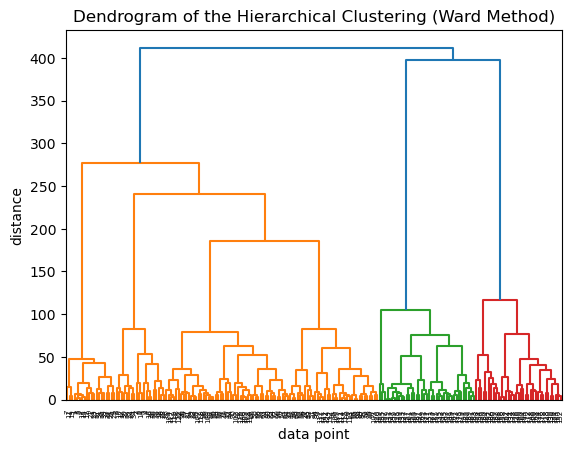

In [21]:
sch.dendrogram(np.array(linkage))
plt.title('Dendrogram of the Hierarchical Clustering (Ward Method)')
plt.xlabel('data point')
plt.ylabel('distance')
plt.show()


# To check

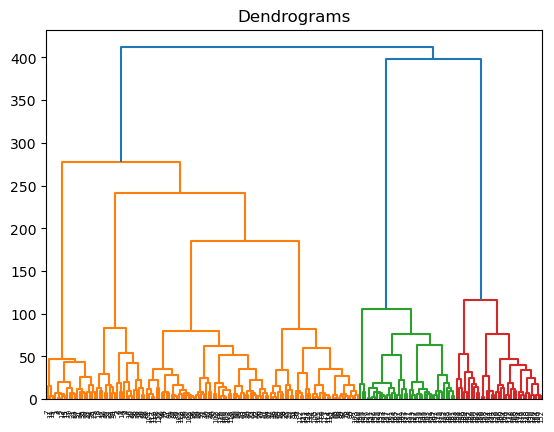

In [22]:
import scipy.cluster.hierarchy as shc
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(np.array(df), method='ward'))

In [23]:
shc.linkage(df, method='ward')

array([[ 65.        ,  68.        ,   1.        ,   2.        ],
       [129.        , 131.        ,   1.        ,   2.        ],
       [  3.        ,   5.        ,   1.73205081,   2.        ],
       [ 48.        ,  49.        ,   2.        ,   2.        ],
       [100.        , 105.        ,   2.23606798,   2.        ],
       [114.        , 115.        ,   2.23606798,   2.        ],
       [147.        , 159.        ,   2.44948974,   2.        ],
       [106.        , 109.        ,   2.82842712,   2.        ],
       [ 92.        ,  96.        ,   3.        ,   2.        ],
       [117.        , 119.        ,   3.        ,   2.        ],
       [156.        , 158.        ,   3.        ,   2.        ],
       [101.        , 208.        ,   3.10912635,   3.        ],
       [ 60.        ,  70.        ,   3.16227766,   2.        ],
       [133.        , 137.        ,   3.16227766,   2.        ],
       [ 13.        ,  15.        ,   3.46410162,   2.        ],
       [ 83.        ,  85